In [ ]:
!pip3 install --upgrade gym
# !pip3 install pytorch
!pip3 install gym.wrappers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 4.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827621 sha256=ab7b8a1fce44d2e3024c61bb005171f18e9af55e451d77de8517c224edec7e1b
  Stored in directory: /root/.cache/pip/wheels/b9/22/6d/3e7b32d98451b4cd9d12417052affbeeeea012955d437da1da
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.0.9 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.
  Preparing metadata (setup.py) ... done
  Created wheel for gym.wrappers: filename=gym_wrappers-0.1.0

In [ ]:
import gym
from gym.spaces import Box
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
import random

from collections import deque
from  torch.autograd import Variable


In [ ]:
class CartPoleOptimalControlEnv(gym.Env):
    """Custom Gym environment for cart-pole system with optimal control."""

    def __init__(self):
        """
        Initialize the environment parameters and action space.
        """
        self.M = 40.0  # Mass of the cart (kg)
        self.mp = 2.0  # Mass of the pole (kg)
        self.L = 0.75  # Length of the pole (m)
        self.g = 10  # Acceleration due to gravity (m/s^2)

        # State space: [cart position (x), cart velocity (x_dot), pole angle (theta), pole angular velocity (theta_dot)]
        POSITIVE_INF = float('inf')  # Define a constant for positive infinity
        NEGATIVE_INF = -float('inf')  # Define a constant for negative infinity
        self.state_space = Box(low=np.array([-100000, NEGATIVE_INF, -np.pi/2, NEGATIVE_INF]),
                                high=np.array([100000, POSITIVE_INF, np.pi/2, POSITIVE_INF]))

        # Action space: Force applied to the cart (Fx)
        self.action_space = Box(low=-5.0, high=5.0)  # Force limits in Newtons

        self.threshold = 195

        # Initial state
        self.reset()

        # Time step (seconds)
        self.dt = 0.02

    def step(self, action):
        """
        Performs one simulation step of the cart-pole system based on the given action.

        Args:
            action: Force applied to the cart (Fx)

        Returns:
            observation (ndarray): The next state of the system.
            reward (float): The reward for the current step.
            done (bool): Whether the episode is finished.
            info (dict): Additional information about the episode.
        """

        # Check if action is within bounds
        if action < self.action_space.low[0] or action > self.action_space.high[0]:
          raise ValueError("Action ({}) out of bounds".format(action))

        # Update time step
        self.t += self.dt

        # Equations of motion
        F_x = action
        tau = (self.M * self.L * self.theta_dot**2 * np.sin(self.theta) + self.M * self.g * self.L * np.cos(self.theta) * np.sin(self.theta)) / \
              (self.M + self.mp * np.sin(self.theta)**2)
        x_ddot = (F_x - self.mp * self.L * (self.theta_dot**2) * np.sin(self.theta)+ self.mp * self.g * (np.sin(self.theta)*np.cos(self.theta))) / \
              (self.M + self.mp * np.sin(self.theta)**2)
        theta_ddot = ((F_x - self.mp * self.L * (self.theta_dot**2) * np.sin(self.theta)) * np.cos(self.theta) + (self.M + self.mp) * self.g * np.sin(self.theta)) / \
              (self.M + self.mp * np.sin(self.theta)**2)*self.L




        # Update state using numerical integration
        self.x_dot += x_ddot * self.dt
        self.x += self.x_dot * self.dt
        self.theta_dot += theta_ddot * self.dt
        self.theta += self.theta_dot * self.dt

        # Terminal conditions
        done = bool(
            self.x < self.state_space.low[0] or
            self.x > self.state_space.high[0] or
            np.abs(self.theta) > np.pi/2 or
            self.t >= 100000  # Maximum episode length
        )

        # Reward function: Encourage staying close to the center and upright position
        # reward =  - np.abs(self.theta) - np.abs(self.x) - np.abs(self.theta_dot) - np.abs(self.x_dot)
        reward =  - (abs(self.theta)**2)-abs(self.theta_dot)**2
        # reward = np.cos(self.theta)


        # Observation (state)
        observation = np.array([self.x, self.x_dot, self.theta, self.theta_dot])

        return observation, reward, done, {}

    def reset(self):
        """
        Resets the environment to the initial state with some randomness.

        Returns:
            observation (ndarray): The initial state of the system with random initial angle.
        """
        self.x = 0.0
        self.x_dot = 0.0
        # Randomize initial angle within a defined range
        self.theta = np.random.uniform(low=-np.pi/2, high=np.pi/2)  # Adjust range as needed
        self.theta_dot = 0.0
        self.t = 0.0
        return np.array([self.x, self.x_dot, self.theta, self.theta_dot])




In [ ]:

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [ ]:
from torch import nn
class PolicyNetwork(nn.Module):
    def __init__(self, obs_space_size, action_space_size):
        super().__init__()

        self.shared_layers = nn.Sequential(
            nn.Linear(obs_space_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU()
        )

        self.policy_mean = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_space_size)
        )

        self.policy_logstd = nn.Parameter(torch.zeros(1, action_space_size))

    def forward(self, obs):
        z = self.shared_layers(obs)
        mean = self.policy_mean(z)
        std = torch.exp(self.policy_logstd).to(device)
        return mean, std

class ValueNetwork(nn.Module):
    def __init__(self, obs_space_size):
        super().__init__()

        self.shared_layers = nn.Sequential(
            nn.Linear(obs_space_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU()
        )

        self.value_layers = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, obs):
        z = self.shared_layers(obs)
        value = self.value_layers(z)
        return value

In [ ]:
from torch import optim
from torch.distributions.categorical import Categorical
from torch.distributions import MultivariateNormal
from torch.distributions import Normal
class PPOTrainer:
    def __init__(self, policy_net,value_net, ppo_clip_val=0.2, target_kl_div=0.01,
                 max_policy_train_iters=80, value_train_iters=80,
                 policy_lr=3e-4, value_lr=1e-2):
        self.policy=policy_net
        self.value=value_net
        self.ppo_clip_val = ppo_clip_val
        self.target_kl_div = target_kl_div
        self.max_policy_train_iters = max_policy_train_iters
        self.value_train_iters = value_train_iters

        policy_params = list(self.policy.shared_layers.parameters()) + \
            list(self.policy.policy_mean.parameters()) + \
            [self.policy.policy_logstd]
        self.policy_optim = optim.Adam(policy_params, lr=policy_lr)

        value_params = list(self.value.shared_layers.parameters()) + \
            list(self.value.value_layers.parameters())
        self.value_optim = optim.Adam(value_params, lr=value_lr)

    def train_policy(self, obs, acts, old_log_probs, gaes):
        for _ in range(self.max_policy_train_iters):
            self.policy_optim.zero_grad()

            new_mean, new_std = self.policy(obs)
            dist = Normal(new_mean, new_std)
            # dist_sample = dist.sample()
            new_log_probs = dist.log_prob(acts).sum(dim=-1)

            policy_ratio = torch.exp(new_log_probs - old_log_probs).to(device)
            clipped_ratio = torch.clamp(policy_ratio, 1 - self.ppo_clip_val, 1 + self.ppo_clip_val).to(device)

            clipped_loss = torch.min(clipped_ratio * gaes, policy_ratio * gaes).to(device)
            policy_loss = -clipped_loss.mean()

            policy_loss.backward()
            self.policy_optim.step()

            kl_div = (old_log_probs - new_log_probs).mean()
            if kl_div >= self.target_kl_div:
                break

    def train_value(self, obs, returns):
        for _ in range(self.value_train_iters):
            self.value_optim.zero_grad()

            values = self.value(obs)
            value_loss = (returns - values) ** 2
            value_loss = value_loss.mean()

            value_loss.backward()
            self.value_optim.step()

In [ ]:
def generate_episode(model, env, max_steps=1000):
    obs = env.reset()
    states = []
    actions = []
    rewards = []
    log_probs = []

    for _ in range(max_steps):
        mean, std = model(torch.tensor([obs], dtype=torch.float32, device=device))

        act_distribution = MultivariateNormal(mean, torch.diag_embed(std).to(device))
        act = act_distribution.sample()
        act_log_prob = act_distribution.log_prob(act).item()

        act = act.item()

        next_obs, reward, done, *_ = env.step(act)
        next_obs = next_obs.ravel()

        obs = next_obs
        states.append(obs)
        actions.append(act)
        rewards.append(reward)
        log_probs.append(act_log_prob)
        if done:
            break

    return states, actions, rewards, log_probs

In [ ]:
env = CartPoleOptimalControlEnv()
policy_model = PolicyNetwork(env.state_space.shape[0], env.action_space.shape[0])
policy_model = policy_model.to(device)

value_model = ValueNetwork(env.state_space.shape[0])
value_model = value_model.to(device)

# Define training params
n_episodes = 100
print_freq = 1

ppo = PPOTrainer(
    policy_model,value_model,
    policy_lr = 3e-4,
    value_lr = 1e-3,
    target_kl_div = 0.02,
    max_policy_train_iters = 100,
    value_train_iters = 100)


In [ ]:
# Training loop
ep_rewards = []
for episode_idx in range(n_episodes):
  obs, actions, rewards, log_probs=generate_episode(policy_model,env)
  ep_rewards.append(np.sum(rewards))
  T=len(rewards)
  gamma=0.99
  Gs = []
  G = 0
  for t in range(T-1,-1,-1): # iterate in backward order to make the computation easier
        G = rewards[t] + gamma*G
        Gs.insert(0,G)
  gaes = torch.tensor(Gs,dtype=torch.float32, device=device).view(-1,1)


  # Policy data
  obs = torch.tensor(obs,
                     dtype=torch.float32, device=device)
  acts = torch.tensor(actions,
                      dtype=torch.int32, device=device)
  act_log_probs = torch.tensor(log_probs,
                               dtype=torch.float32, device=device)

  # # Value data
  # returns = discount_rewards(train_data[2])[permute_idxs]
  # returns = torch.tensor(returns, dtype=torch.float32, device=device)

  # Train model
  ppo.train_policy(obs, acts, act_log_probs, gaes)
  ppo.train_value(obs, gaes)

  if (episode_idx + 1) % print_freq == 0:
    print('Episode {} | Avg Reward {:.1f}'.format(
        episode_idx + 1, np.mean(ep_rewards[-print_freq:])))

Episode 1 | Avg Reward -36.5
Episode 2 | Avg Reward -39.1
Episode 3 | Avg Reward -31.7
Episode 4 | Avg Reward -21.9
Episode 5 | Avg Reward -27.8
Episode 6 | Avg Reward -35.1
Episode 7 | Avg Reward -33.4
Episode 8 | Avg Reward -32.4
Episode 9 | Avg Reward -28.0
Episode 10 | Avg Reward -7.7
Episode 11 | Avg Reward -30.4
Episode 12 | Avg Reward -38.0
Episode 13 | Avg Reward -41.3
Episode 14 | Avg Reward -38.4
Episode 15 | Avg Reward -37.7
Episode 16 | Avg Reward -31.1
Episode 17 | Avg Reward -27.3
Episode 18 | Avg Reward -37.4
Episode 19 | Avg Reward -31.4
Episode 20 | Avg Reward -32.8
Episode 21 | Avg Reward -37.8
Episode 22 | Avg Reward -41.6
Episode 23 | Avg Reward -29.3
Episode 24 | Avg Reward -27.5
Episode 25 | Avg Reward -27.8
Episode 26 | Avg Reward -39.7
Episode 27 | Avg Reward -38.3
Episode 28 | Avg Reward -34.9
Episode 29 | Avg Reward -35.9
Episode 30 | Avg Reward -36.4
Episode 31 | Avg Reward -38.8
Episode 32 | Avg Reward -36.9
Episode 33 | Avg Reward -31.3
Episode 34 | Avg Rew

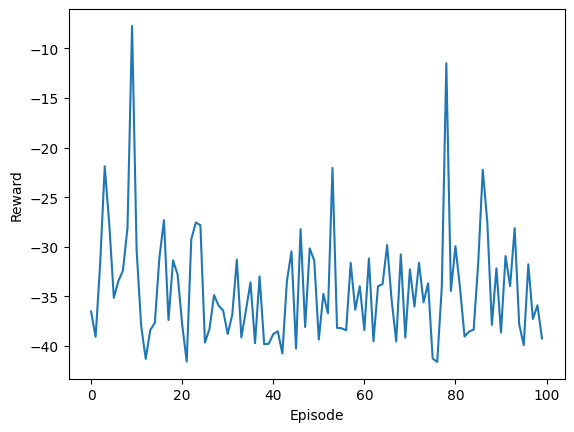

In [ ]:

import matplotlib.pyplot as plt
plt.plot(np.arange(len(ep_rewards)), ep_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def evaluate_ppo(env, policy_model,angle):
  rewards = []
  control_inputs = []
  states = []
  for _ in range(1):
    state = env.reset()
    state[2]=angle
    episode_rewards = []
    episode_control_inputs = []
    episode_states = []
    done = False
    while not done:
      mean,std=policy_model(torch.FloatTensor(state))
      # action = agent.act(state)
      act_distribution = MultivariateNormal(mean, torch.diag_embed(std).to(device))
      action = act_distribution.sample().item()
      # print(action)
      next_state, reward, done, info = env.step(action)
      episode_rewards.append(reward)
      episode_control_inputs.append(action)
      episode_states.append(state)
      state = next_state
    rewards.append(sum(episode_rewards))
    control_inputs.append(np.array(episode_control_inputs))
    states.append(np.array(episode_states))
  return rewards, control_inputs, states


rewards, control_inputs, states = evaluate_ppo(env, policy_model,1.0472)




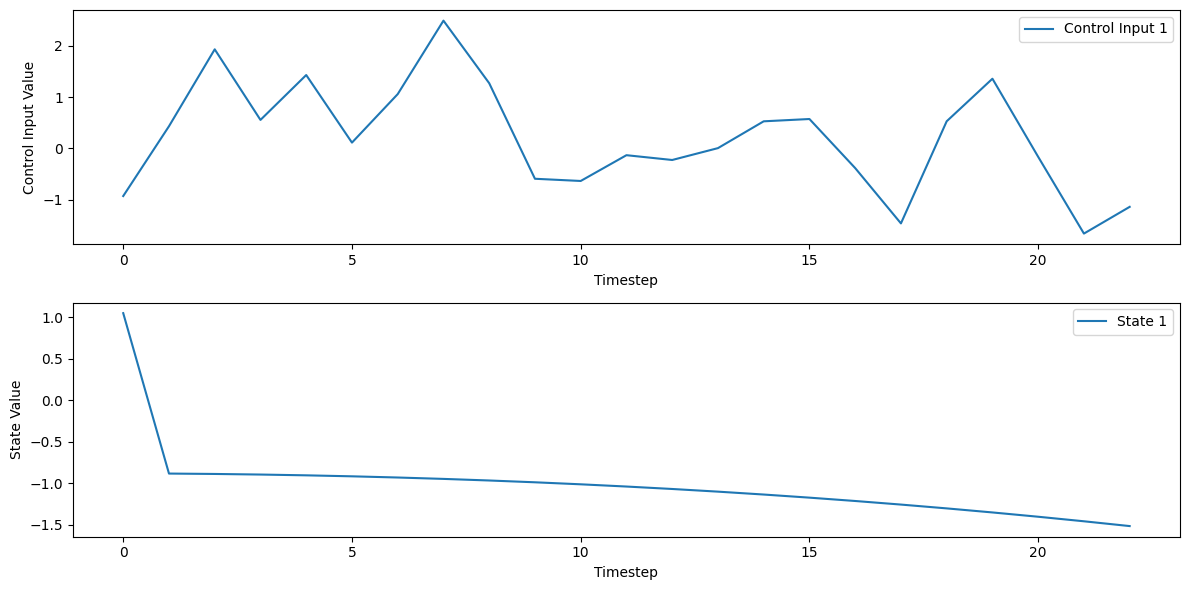

In [ ]:
rewards, control_inputs, states = evaluate_ppo(env, policy_model,1.0472)
# Assuming 'episode_idx' is the index of the chosen episode
episode_ctrl_inputs = control_inputs[0]
episode_states = states[0]
plt.figure(figsize=(12, 6))

# Control input plot
plt.subplot(211)
# for dim in range(len(episode_ctrl_inputs)):  # Assuming multiple dimensions
plt.plot(episode_ctrl_inputs, label=f'Control Input {1}')
plt.xlabel('Timestep')
plt.ylabel('Control Input Value')
plt.legend()

# State plot (assuming multiple dimensions)
plt.subplot(212)
# for dim in range(len(episode_states[0])):
plt.plot(episode_states[:,2], label=f'State {1}')
plt.xlabel('Timestep')
plt.ylabel('State Value')
plt.legend()

plt.tight_layout()
plt.show()


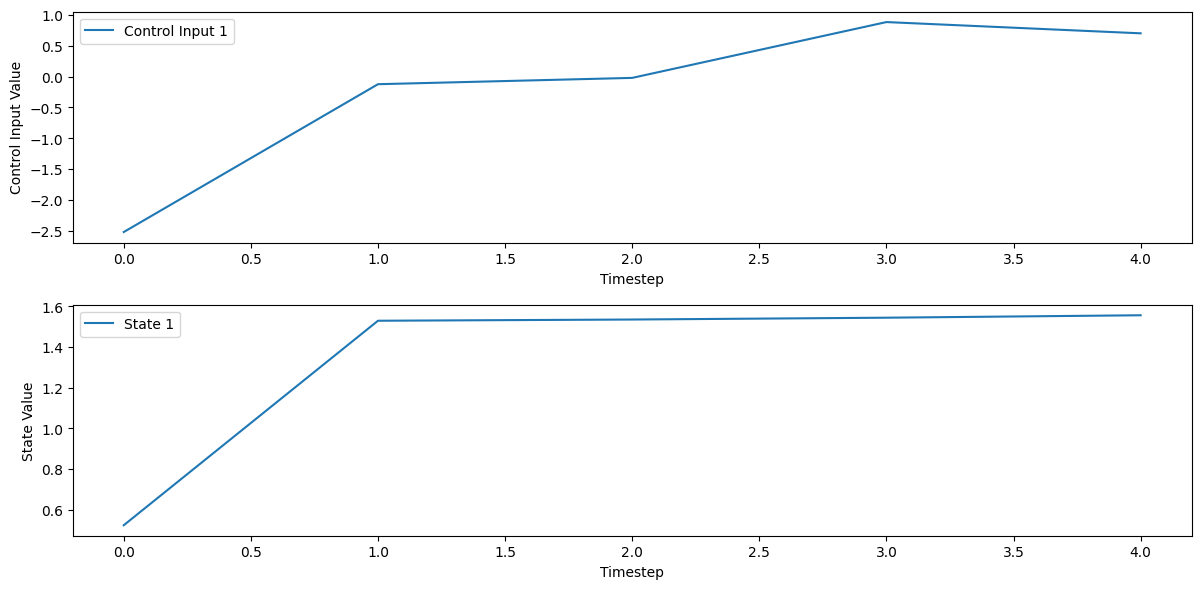

In [ ]:
rewards, control_inputs, states = evaluate_ppo(env, policy_model,0.5236)
# Assuming 'episode_idx' is the index of the chosen episode
episode_ctrl_inputs = control_inputs[0]
episode_states = states[0]
plt.figure(figsize=(12, 6))

# Control input plot
plt.subplot(211)
# for dim in range(len(episode_ctrl_inputs)):  # Assuming multiple dimensions
plt.plot(episode_ctrl_inputs, label=f'Control Input {1}')
plt.xlabel('Timestep')
plt.ylabel('Control Input Value')
plt.legend()

# State plot (assuming multiple dimensions)
plt.subplot(212)
# for dim in range(len(episode_states[0])):
plt.plot(episode_states[:,2], label=f'State {1}')
plt.xlabel('Timestep')
plt.ylabel('State Value')
plt.legend()

plt.tight_layout()
plt.show()


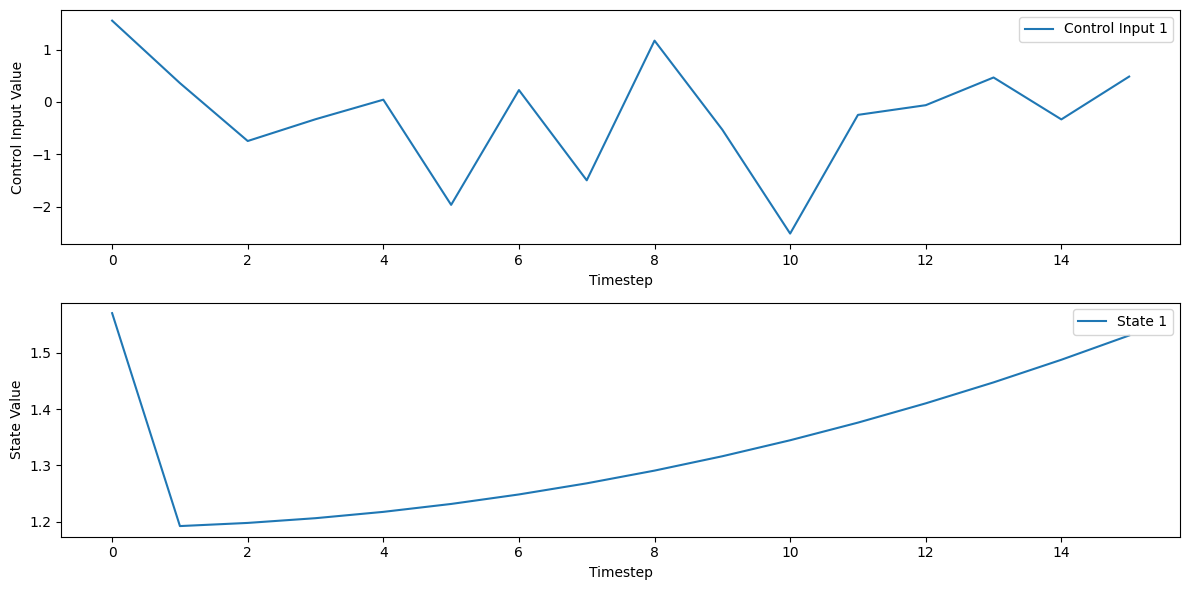

In [ ]:

rewards, control_inputs, states = evaluate_ppo(env, policy_model,1.5708)
# Assuming 'episode_idx' is the index of the chosen episode
episode_ctrl_inputs = control_inputs[0]
episode_states = states[0]
plt.figure(figsize=(12, 6))
# print(states[0])
# print(episode_states[:,0])
# Control input plot
plt.subplot(211)
# for dim in range(len(episode_ctrl_inputs)):  # Assuming multiple dimensions
plt.plot(episode_ctrl_inputs, label=f'Control Input {1}')
plt.xlabel('Timestep')
plt.ylabel('Control Input Value')
plt.legend()

# State plot (assuming multiple dimensions)
plt.subplot(212)
# for dim in range(len(episode_states[0])):
plt.plot(episode_states[:,2], label=f'State {1}')
plt.xlabel('Timestep')
plt.ylabel('State Value')
plt.legend()

plt.tight_layout()
plt.show()
